<a href="https://colab.research.google.com/github/lordkevinmo/bertelsmann-tech-scholarship-challenge/blob/master/kernel79bfe92745.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [9]:
!pip install kaggle

In [0]:
!mkdir -p ~/.kaggle

In [11]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevinmose","key":"20df5777b152e64e8277204013bc12c1"}'}

In [0]:

!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d elderyouth/chinese-zodiac-signs

100% 2.06G/2.07G [00:23<00:00, 33.3MB/s]
100% 2.07G/2.07G [00:23<00:00, 93.4MB/s]


In [14]:
!unzip chinese-zodiac-signs.zip

Archive:  chinese-zodiac-signs.zip
  inflating: signs/test/dog/00000004.jpg  
  inflating: signs/test/dog/00000005.jpg  
  inflating: signs/test/dog/00000010.jpg  
  inflating: signs/test/dog/00000011.jpg  
  inflating: signs/test/dog/00000038.jpg  
  inflating: signs/test/dog/00000039.jpg  
  inflating: signs/test/dog/00000144.jpeg  
  inflating: signs/test/dog/00000164.jpg  
  inflating: signs/test/dog/00000165.jpg  
  inflating: signs/test/dog/00000167.jpg  
  inflating: signs/test/dog/00000170.jpg  
  inflating: signs/test/dog/00000173.jpg  
  inflating: signs/test/dog/00000206.jpg  
  inflating: signs/test/dog/00000207.jpg  
  inflating: signs/test/dog/00000212.jpg  
  inflating: signs/test/dog/00000213.jpg  
  inflating: signs/test/dog/00000359.jpg  
  inflating: signs/test/dog/00000365.jpg  
  inflating: signs/test/dog/00000366.jpg  
  inflating: signs/test/dog/00000371.jpg  
  inflating: signs/test/dog/00000372.jpg  
  inflating: signs/test/dog/00000373.jpg  
  inflating: signs

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25


In [0]:
def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(5)))
  plt.imshow(img)
  plt.axis('off')

In [0]:
!pip install imgaug
from imgaug import augmenters as iaa
import imgaug as ia

In [0]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

dirname = 'signs/'

In [0]:
class ImageAugmentation:
    def __init__(self):
        self.transform = iaa.Sequential([
            iaa.Scale((240, 240)),
            iaa.CropAndPad(percent=(-0.2,0.2), pad_mode="edge"), # crop and pad images
            iaa.AddToHueAndSaturation(value = (-10, 10), per_channel=True), # change their color
            #iaa.ElasticTransformation(alpha=90, sigma=0.9), # water-like effect 
            #iaa.AdditiveGaussianNoise(scale=(30, 90)), #add gaussian noise to the image
            iaa.Crop(percent=(0, 0.4)),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),
            iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout((0.01, 0.1), size_percent=0.5)]))
        ], random_order=True)
    
    def __call__(self, img):
        img = np.array(img)
        return self.transform.augment_image(img)


In [7]:
!pip install nonechucks

  Created wheel for nonechucks: filename=nonechucks-0.4.0-cp36-none-any.whl size=11546 sha256=018a29d383086c067fba60fb678628cd214d0e03ec4a0d02321926fbc19be687
  Stored in directory: /root/.cache/pip/wheels/00/b3/4e/4e30d5f934293de9abab2bfe6a4ce6fe77bf936c625133dd9c
Successfully built nonechucks


In [0]:
import nonechucks

train_transform = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.RandomPerspective(),
                                      transforms.ColorJitter(hue=.05, saturation=.05),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(240),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(dirname + 'train', transform=train_transform)
validation_dataset = datasets.ImageFolder(dirname + 'valid', transform=train_transform)
test_dataset = datasets.ImageFolder(dirname + 'test', transform=test_transform)

train_data = nonechucks.SafeDataset(train_dataset)
valid_data = nonechucks.SafeDataset(validation_dataset)
test_data = nonechucks.SafeDataset(test_dataset)

In [0]:
from torch.utils.data import DataLoader as loader

batch_size = 16

trainloader = loader(train_data, batch_size=batch_size, shuffle=True)
validloader = loader(valid_data, batch_size=batch_size, shuffle=True)
testloader = loader(test_data, batch_size=batch_size)

In [20]:
model = models.resnext101_32x8d(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:14<00:00, 23.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [0]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Freeze parameters
for param in model.parameters():
    param.requires_grad = False

In [27]:
from collections import OrderedDict

classifier = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(64,12),
    nn.LogSoftmax(dim=1)
)


model.fc = classifier

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [28]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# number of epochs to train the model
n_epochs = 40

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(validloader):
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_chinese_zod_resnet152.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 24.912860 	Validation Loss: 14.569898
Validation loss decreased (inf --> 14.569898).  Saving model ...
Epoch: 1 	Training Loss: 17.418447 	Validation Loss: 12.029656
Validation loss decreased (14.569898 --> 12.029656).  Saving model ...
Epoch: 2 	Training Loss: 16.018852 	Validation Loss: 11.992748
Validation loss decreased (12.029656 --> 11.992748).  Saving model ...
Epoch: 3 	Training Loss: 15.368718 	Validation Loss: 12.011701
Epoch: 4 	Training Loss: 14.724324 	Validation Loss: 11.836430
Validation loss decreased (11.992748 --> 11.836430).  Saving model ...
Epoch: 5 	Training Loss: 14.166366 	Validation Loss: 11.956770
Epoch: 6 	Training Loss: 13.922956 	Validation Loss: 11.593153
Validation loss decreased (11.836430 --> 11.593153).  Saving model ...
Epoch: 7 	Training Loss: 13.538856 	Validation Loss: 11.925630
Epoch: 8 	Training Loss: 13.195992 	Validation Loss: 12.099355
Epoch: 9 	Training Loss: 13.116423 	Validation Loss: 13.345479
Epoch: 10 	Training L

In [29]:
model.load_state_dict(torch.load('model_chinese_zod_resnet152.pt'))

<All keys matched successfully>

In [31]:

test_loss = 0.
correct = 0.
total = 0.

model.eval()
for batch_idx, (data, target) in enumerate(testloader):
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update average test loss 
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    100. * correct / total, correct, total))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss: 0.286731


Test Accuracy: 90% (599/660)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

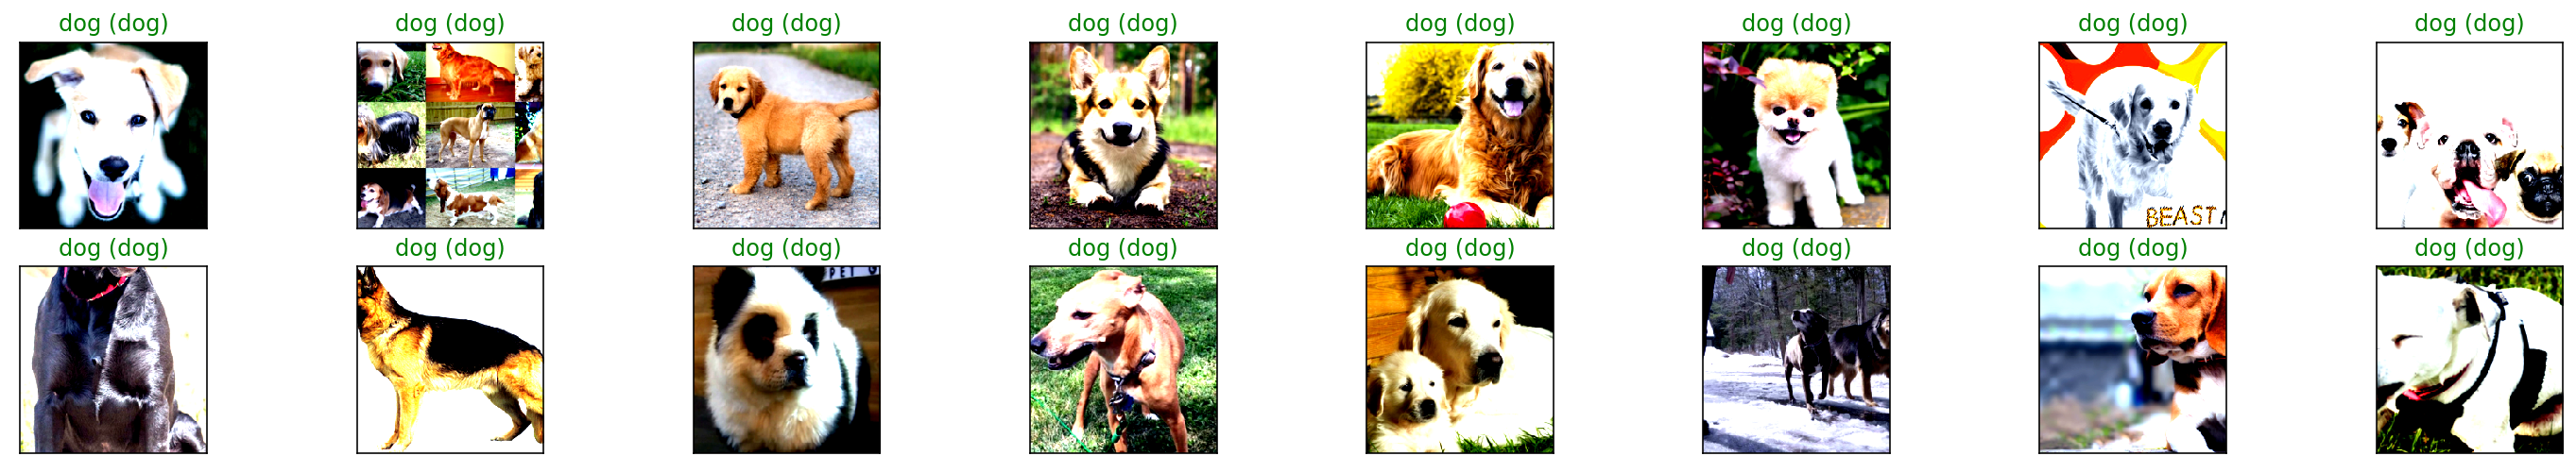

In [33]:
Chinese_zodiac_names= ['dog', 'dragon', 'goat', 'horse', 'monkey', 'ox', 'pig', 'rabbit', 
           'ratt', 'rooster', 'snake', 'tiger']

def imshow(img):
    # unnormalize
    img = img / 2 + 0.5  
    # convert from Tensor image
    plt.imshow(np.transpose(img, (1, 2, 0)))  

dataiter=iter(testloader)
images,labels=dataiter.next()
images.numpy()
#move model inputs to cuda, if GPU available
if device:
    images=images.cuda()
#get sample outputs
output=model(images)
# convert output probabilities to predicted class
_, preds_tensor=torch.max(output,1)
preds=np.squeeze(preds_tensor.numpy()) if not device else np.squeeze(preds_tensor.cpu().numpy())

#plot the images in the batch, along with predicted and true labels
fig=plt.figure(figsize=(25,4))
for idx in np.arange(16):
    ax=fig.add_subplot(2,16/2,idx+1,xticks=[],yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(Chinese_zodiac_names[preds[idx]],Chinese_zodiac_names[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [34]:
model_wresnet = models.wide_resnet101_2(pretrained=True, progress=True)
model_wresnet

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/checkpoints/wide_resnet101_2-32ee1156.pth
100%|██████████| 243M/243M [00:26<00:00, 9.65MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [0]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Freeze parameters
for param in model_wresnet.parameters():
    param.requires_grad = False

In [47]:
classifier = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(64,12),
    nn.LogSoftmax(dim=1)
)


model_wresnet.fc = classifier

criterion = nn.NLLLoss()

optimizer = optim.Adam(model_wresnet.fc.parameters(), lr=0.001)

model_wresnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [48]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
losses = []
trains = []
for epoch in range(n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model_wresnet.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_wresnet(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        trains.append(train_loss)
        
    ######################    
    # validate the model #
    ######################
    model_wresnet.eval()
    for batch_idx, (data, target) in enumerate(validloader):
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_wresnet(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        losses.append(valid_loss)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_wresnet.state_dict(), 'model_chinese_zod_w_resnet101.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 29.268231 	Validation Loss: 19.618912
Validation loss decreased (inf --> 19.618912).  Saving model ...
Epoch: 1 	Training Loss: 21.536630 	Validation Loss: 16.449314
Validation loss decreased (19.618912 --> 16.449314).  Saving model ...
Epoch: 2 	Training Loss: 20.091127 	Validation Loss: 14.571620
Validation loss decreased (16.449314 --> 14.571620).  Saving model ...
Epoch: 3 	Training Loss: 19.211175 	Validation Loss: 15.687140
Epoch: 4 	Training Loss: 18.686887 	Validation Loss: 14.727683
Epoch: 5 	Training Loss: 18.262280 	Validation Loss: 14.520604
Validation loss decreased (14.571620 --> 14.520604).  Saving model ...
Epoch: 6 	Training Loss: 17.807718 	Validation Loss: 14.341123
Validation loss decreased (14.520604 --> 14.341123).  Saving model ...
Epoch: 7 	Training Loss: 17.397257 	Validation Loss: 14.474220
Epoch: 8 	Training Loss: 17.372916 	Validation Loss: 14.908784
Epoch: 9 	Training Loss: 17.295458 	Validation Loss: 14.297956
Validation loss decre

In [0]:
trains[:] = [x / len(trainloader) for x in trains]
losses[:] = [x / len(validloader) for x in losses]

In [53]:
model_wresnet.load_state_dict(torch.load('model_chinese_zod_w_resnet101.pt'))


<All keys matched successfully>

In [54]:
test_loss = 0.
correct = 0.
total = 0.

model_wresnet.eval()
for batch_idx, (data, target) in enumerate(testloader):
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_wresnet(data)
    # calculate the loss
    loss = criterion(output, target)
    # update average test loss 
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    100. * correct / total, correct, total))

Test Loss: 0.649803


Test Accuracy: 84% (559/660)
